In [1]:
from fastbook import *

In [2]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [3]:
path.ls()

(#50) [Path('/root/.fastai/data/biwi_head_pose/15'),Path('/root/.fastai/data/biwi_head_pose/18.obj'),Path('/root/.fastai/data/biwi_head_pose/16.obj'),Path('/root/.fastai/data/biwi_head_pose/11.obj'),Path('/root/.fastai/data/biwi_head_pose/06'),Path('/root/.fastai/data/biwi_head_pose/24.obj'),Path('/root/.fastai/data/biwi_head_pose/23.obj'),Path('/root/.fastai/data/biwi_head_pose/01'),Path('/root/.fastai/data/biwi_head_pose/07.obj'),Path('/root/.fastai/data/biwi_head_pose/20')...]

In [4]:
(path/'01').ls()

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/frame_00160_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00005_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00308_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00418_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00190_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00430_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00307_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00047_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00194_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00043_rgb.jpg')...]

In [5]:
img_files = get_image_files(path)

In [6]:
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('/root/.fastai/data/biwi_head_pose/15/frame_00461_pose.txt')

In [96]:
im = PILImage.create(img_files[7100])

In [92]:
im.shape

(480, 640)

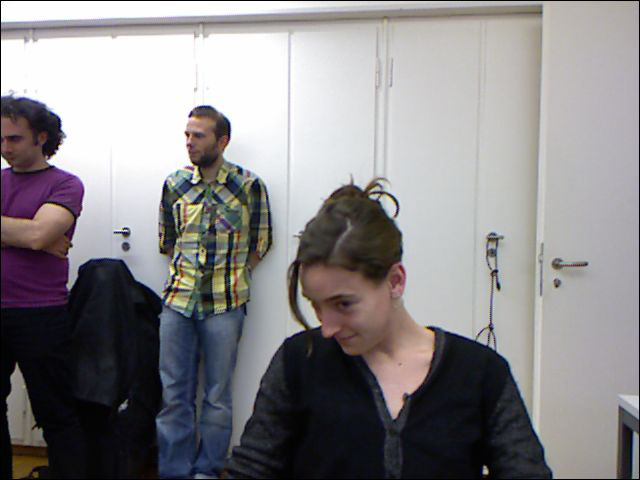

In [97]:
im

In [146]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [147]:
get_ctr(img_files[1])

tensor([[335.4659, 304.2489],
        [304.2489, 335.4659]])

In [151]:
img_files[1]

Path('/root/.fastai/data/biwi_head_pose/15/frame_00284_rgb.jpg')

In [148]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

In [149]:
dls = biwi.dataloaders(path)

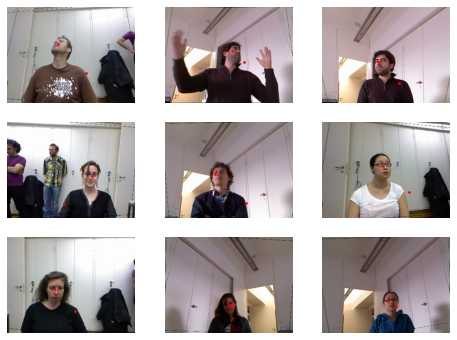

In [150]:
dls.show_batch(max_n=9, figsize=(8,6))

In [122]:
xb, yb = dls.one_batch()

In [123]:
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [125]:
learn = cnn_learner(dls, resnet18, y_range=(-1, 1))

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [126]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

In [127]:
dls.loss_func

FlattenedLoss of MSELoss()

/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.001737800776027143)

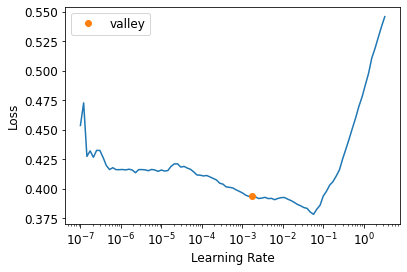

In [128]:
learn.lr_find()

In [129]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.048615,0.039218,00:39


epoch,train_loss,valid_loss,time
0,0.007902,0.002108,00:42
1,0.003093,0.002391,00:43
2,0.001405,0.000290,00:43


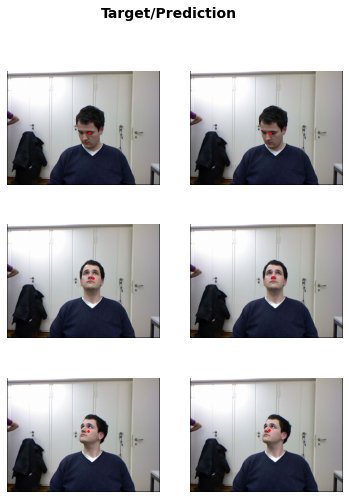

In [145]:
learn.show_results(ds_idx=1, max_n=3, figsize=(6, 8), shuffle=True)

In [135]:
learn.show_results?